# DLProfile Example using Distributed FFN Application

## Set imports and neccessary environment variables

In [1]:
import pathlib
import os
import sys
import matplotlib.pyplot as plt
import warnings
import pprint
import pandas as pd
import tensorflow as tf

In [2]:
VANIDL_DIR="{}".format(pathlib.Path(os.getcwd()).parent.parent.parent.absolute())
sys.path.insert(0, VANIDL_DIR)
warnings.filterwarnings('ignore')

In [3]:
os.environ["DARSHAN_DIR"] = "/soft/perftools/darshan/darshan-3.1.8"
os.environ["VANIDL_DIR"] = VANIDL_DIR

### Formatting

In [4]:
pp = pprint.PrettyPrinter(indent=1)
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

## Create instrance of DL Profile and load the darshan file

In [5]:
from src.vanidl import VaniDL
profile = VaniDL()

In [6]:
DATAPATH_INCLUDES = []
status = profile.Load("/home/dhari/darshan-logs/benchmark/ffn/ffn_run1_p8.darshan", data_paths_include=DATAPATH_INCLUDES)
if status:
    print("Darshan Trace loaded Successfully!")
else:
    print("Darshan Trace load Failed!")
    print(profile._error_str())

[============================================================] 100.0% 1198 of 1198 Parsing DXT File 
[============================================================] 100.0% 2695 of 2695 Parsing Darshan File 
Darshan Trace loaded Successfully!


## Use Profile object to analyze the darshan I/O trace.

### Verify if object works

The GetDXTAsDF() function enables users to perform analysis 

In [7]:
pd.set_option('display.max_colwidth', -1)
df = profile.GetDXTAsDF()
pp.pprint("Files used in the application")
pp.pprint(df['Filename'].unique().tolist())

'Files used in the application'
['/projects/datascience/dhari/dlio_datasets/ffn/img_0_of_1.h5']


### Collect the summary of the Application

In [8]:
summary = profile.GetSummary()
print("\n")
print(color.BOLD + "Data Access Summary (from Darshan):"+ color.END)
print("Total Job time\t\t\t:\t{:0.2f} seconds".format(summary['job_time']))
#FIXME: calculate time per rank and then take max across it.
print("Time spent in I/O\t\t:\t{:0.2f} seconds".format(summary['total_io_time']))
print("% Time spent in I/O\t\t:\t{:0.2f}%".format(float(summary['total_io_time'])*100/summary['job_time']))
print("Total Data Accessed\t\t:\t{:0.2f} GB".format(float(summary['total_io_bytes'])/1024.0/1024.0/1024.0))
print("Data Access Modules used\t:\t{}".format(summary['io_interface_used']))
print("Data Operations\t\t\t:\t{}".format(summary['io_operations_used']))
print("# of files used\t\t\t:\t{}".format(len(summary['files_used'])))
print("# of MPI Ranks\t\t\t:\t{:0.0f} ranks".format(summary['num_ranks']))
      
print(color.UNDERLINE + "Data Transfer size:"+ color.END)
print("\tMin,Max\t\t\t:\t{:0.0f} bytes and {:0.0f} bytes".format(summary['data_transfer_size']['min'],summary['data_transfer_size']['max']))
print("\tAverage\t\t\t:\t{:0.0f} bytes".format(summary['data_transfer_size']['mean']))
print("\tMedian\t\t\t:\t{:0.0f} bytes".format(summary['data_transfer_size']['median']))
      
print(color.UNDERLINE + "Data Transfer bandwidth: (per rank)"+ color.END)
print("\tMin,Max\t\t\t:\t{:0.0f} B/s and {:0.0f} MB/s".format(summary['data_transfer_bandwidth']['min'],summary['data_transfer_bandwidth']['max']/1024.0/1024.0))
print("\tAverage\t\t\t:\t{:0.0f} MB/s".format(summary['data_transfer_bandwidth']['mean']/1024.0/1024.0))
print("\tMedian\t\t\t:\t{:0.0f} MB/s".format(summary['data_transfer_bandwidth']['median']/1024.0/1024.0))
      
print(color.UNDERLINE + "Access Pattern:"+ color.END)
print("\tSequential\t\t:\t{:0.2f}%".format(float(summary['access_pattern']['sequential'])))
print("\tConsecutive\t\t:\t{:0.2f}%".format(float(summary['access_pattern']['consecutive'])))
#An I/O op issued at an offset greater than where the previous I/O op ended.
#An I/O op issued at the offset immediately after the end of the previous I/O

print("\n")
print(color.BOLD + "Files Summary:"+ color.END)
print("File Types\t\t\t:\t{}".format(summary['file_used_summary']['types']))
print(color.UNDERLINE + "Dataset Size:"+ color.END)
print("\tTotal\t\t\t:\t{:0.3f} GB".format(float(summary['file_used_summary']['size']['total'])/1024.0/1024.0/1024.0))
print("\tMin,Max\t\t\t:\t{:0.3f} GB and {:0.3f} GB".format(float(summary['file_used_summary']['size']['min'])/1024.0/1024.0/1024.0,float(summary['file_used_summary']['size']['max'])/1024.0/1024.0/1024.0))
print("\tAverage\t\t\t:\t{:0.3f} GB".format(float(summary['file_used_summary']['size']['mean'])/1024.0/1024.0/1024.0))



Data Access Summary (from Darshan):
Total Job time			:	2.00 seconds
Time spent in I/O		:	0.03 seconds
% Time spent in I/O		:	1.59%
Total Data Accessed		:	0.00 GB
Data Access Modules used	:	['X_POSIX']
Data Operations			:	['read']
# of files used			:	1
# of MPI Ranks			:	8 ranks
Data Transfer size:
	Min,Max			:	8 bytes and 544 bytes
	Average			:	314 bytes
	Median			:	420 bytes
Data Transfer bandwidth: (per rank)
	Min,Max			:	432 B/s and 5 MB/s
	Average			:	1 MB/s
	Median			:	0 MB/s
Access Pattern:
	Sequential		:	50.00%
	Consecutive		:	25.00%


Files Summary:
File Types			:	['h5']
Dataset Size:
	Total			:	0.125 GB
	Min,Max			:	0.125 GB and 0.125 GB
	Average			:	0.125 GB


In [9]:
pp.pprint("Job time : {} seconds".format(profile.GetJobTime()))

'Job time : 2.0 seconds'


In [10]:
pp.pprint("Time spent by application on I/O: {} seconds".format(profile.GetIOTime()))

'Time spent by application on I/O: 0.03180000000000001 seconds'


### I/O time spent on each file

In [11]:
for file in df['Filename'].unique():
    print("I/O time for file {}: {:0.2f} seconds".format(file,profile.GetIOTime(filepath=file)))

I/O time for file /projects/datascience/dhari/dlio_datasets/ffn/img_0_of_1.h5: 0.03 seconds


### I/O Time spent per rank

In [12]:
for rank in df['Rank'].unique()[:16]:
    print("I/O time for rank {}: {:0.2f} seconds".format(rank,profile.GetIOTime(rank=rank)))

I/O time for rank 0: 0.03 seconds
I/O time for rank 1: 0.03 seconds
I/O time for rank 2: 0.03 seconds
I/O time for rank 3: 0.03 seconds
I/O time for rank 4: 0.03 seconds
I/O time for rank 5: 0.03 seconds
I/O time for rank 6: 0.03 seconds
I/O time for rank 7: 0.03 seconds


In [13]:
"Total I/O performed by application: {:0.2f} GB".format(float(profile.GetIOSize())/1024.0/1024.0/1024.0)

'Total I/O performed by application: 0.00 GB'

### I/O performed on each file

In [14]:
for file in df['Filename'].unique()[:16]:
    print("I/O performed on file {}: {:0.2f} MB".format(file,float(profile.GetIOSize(filepath=file))/1024.0/1024.0))

I/O performed on file /projects/datascience/dhari/dlio_datasets/ffn/img_0_of_1.h5: 0.04 MB


In [15]:
for rank in df['Rank'].unique()[:16]:
    print("I/O performed by rank {}: {:0.2f} MB".format(rank, float(profile.GetIOSize(rank=rank))/1024.0/1024.0))

I/O performed by rank 0: 0.00 MB
I/O performed by rank 1: 0.00 MB
I/O performed by rank 2: 0.00 MB
I/O performed by rank 3: 0.00 MB
I/O performed by rank 4: 0.00 MB
I/O performed by rank 5: 0.00 MB
I/O performed by rank 6: 0.00 MB
I/O performed by rank 7: 0.00 MB


In [16]:
sizes = profile.GetFileSizes()
for key in sizes:
    sizes[key] = sizes[key]/1024.0/1024.0
print("Size of dataset (MB)")
pp.pprint(sizes)

Size of dataset (MB)
{'img_0_of_1': 128.033203125}


### How application access data over time.

[============================================================] 100.0% 128 of 128 Creating Timeline 


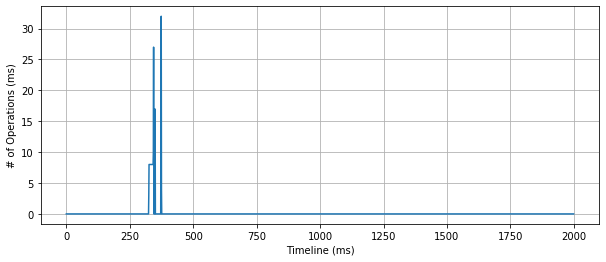

In [17]:
tl = profile.CreateIOTimeline(time_step=0.001)
plt.figure(figsize=(10,4))
plt.xlabel("Timeline (ms)")
plt.ylabel("# of Operations (ms)")
plt.grid()
plt.plot(tl['time_step'], tl['operation_count']);

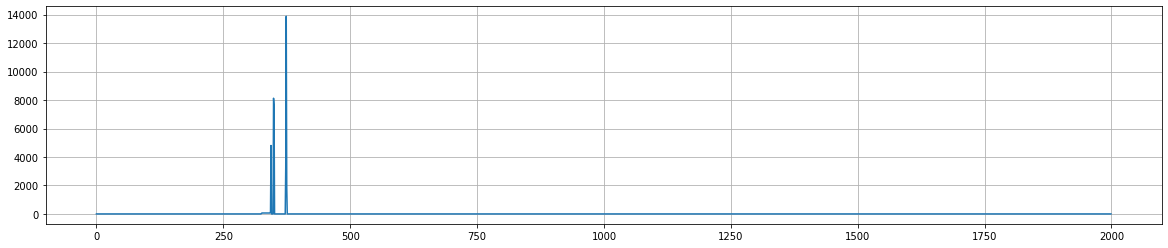

In [18]:
plt.figure(figsize=(20,4))
plt.grid()
plt.plot(tl['time_step'], tl['io_bytes']);

### How files are accessed over the duration of the Job.

[============================================================] 100.0% 128 of 128 Creating Timeline 


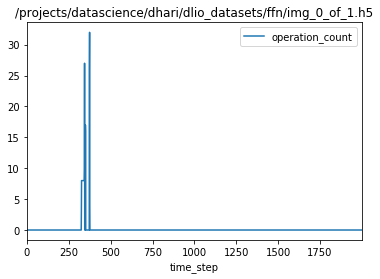

In [19]:
for file in df['Filename'].unique():
    tl = profile.CreateIOTimeline(filepath=file, time_step=0.001)
    tl.plot(x='time_step',y='operation_count', title=file)
    plt.show()

### Show how each file is accessed by each rank.

[============================================================] 100.0% 16 of 16 Creating Timeline 


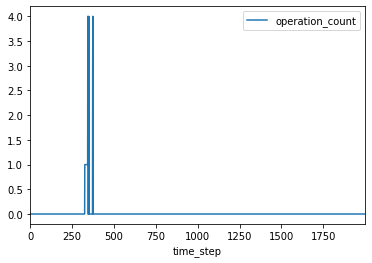

[============================================================] 100.0% 16 of 16 Creating Timeline 


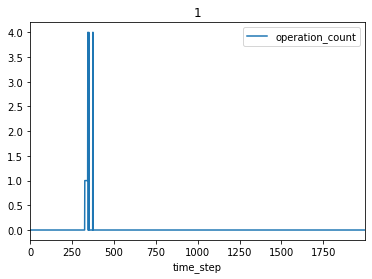

[============================================================] 100.0% 16 of 16 Creating Timeline 


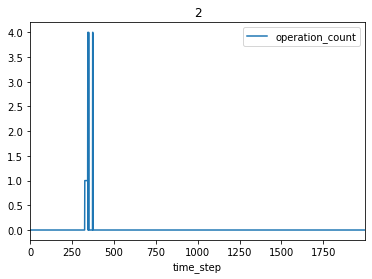

[============================================================] 100.0% 16 of 16 Creating Timeline 


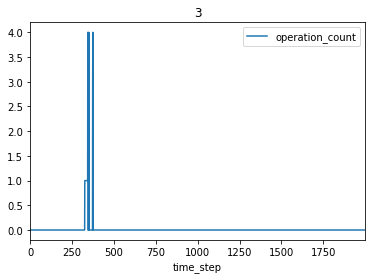

[============================================================] 100.0% 16 of 16 Creating Timeline 


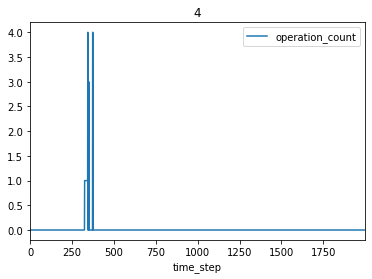

[============================================================] 100.0% 16 of 16 Creating Timeline 


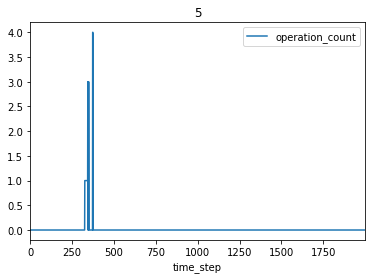

[============================================================] 100.0% 16 of 16 Creating Timeline 


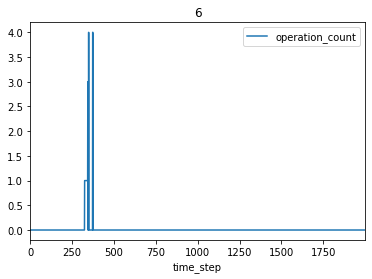

[============================================================] 100.0% 16 of 16 Creating Timeline 


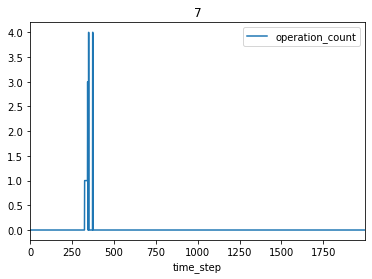

In [20]:
for rank in df['Rank'].unique()[:16]:
    tl = profile.CreateIOTimeline(rank=rank, time_step=0.001)
    tl.plot(x='time_step',y='operation_count', title=rank)
    plt.show()

### Data Transfer Size distribution within the application

Text(0.5, 0, 'Transfer Size (bytes)')

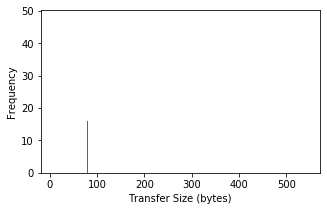

In [26]:
request_df = profile.GetIORequestDistribution()
df['Length'].plot(kind='hist', figsize=(5, 3),bins=1000);
plt.xlabel("Transfer Size (bytes)")

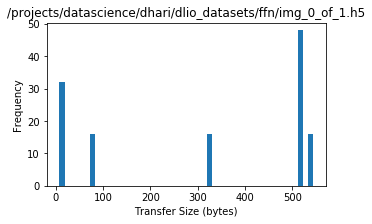

In [22]:
for file in df['Filename'].unique():
    #tl = profile.GetIORequestDistribution(filepath=file, bins=50)
    tl = df[df["Filename"].eq(file)]
    tl['Length'].plot(kind='hist', figsize=(5, 3),bins=50);
    plt.xlabel("Transfer Size (bytes)")
    plt.title(file)
    plt.show()

### Data Transfer Sizes per Rank

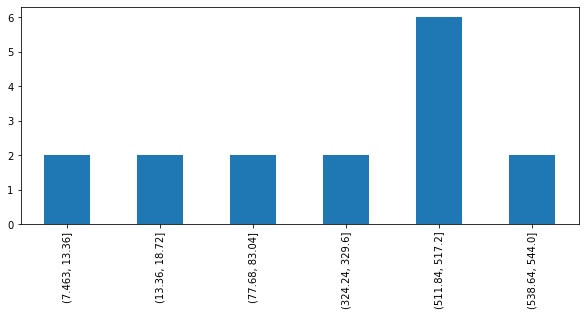

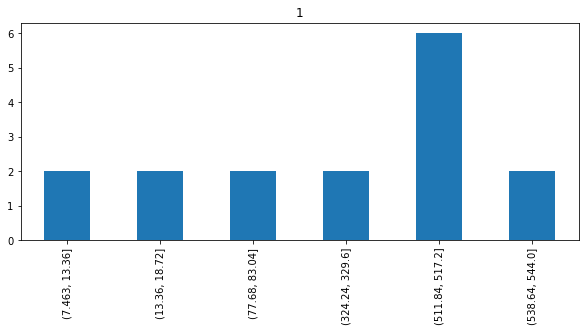

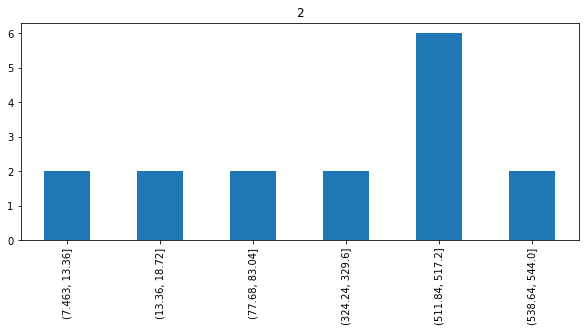

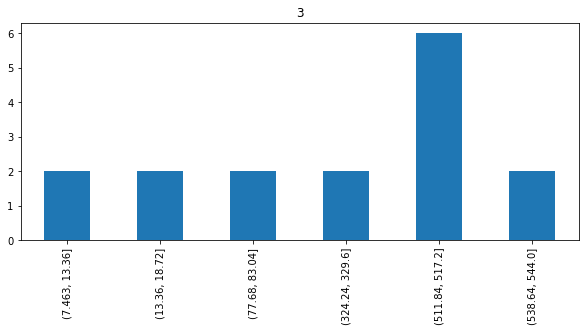

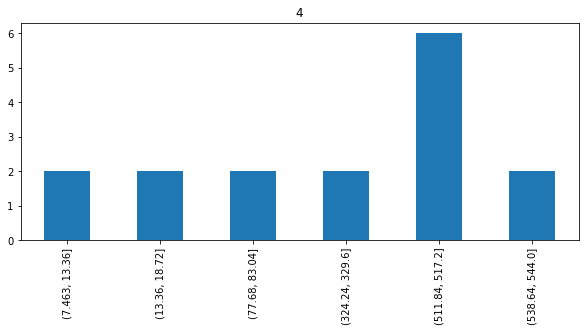

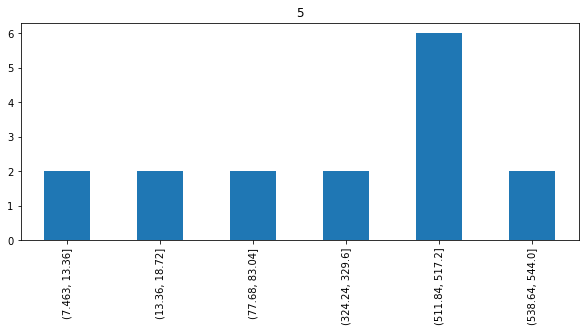

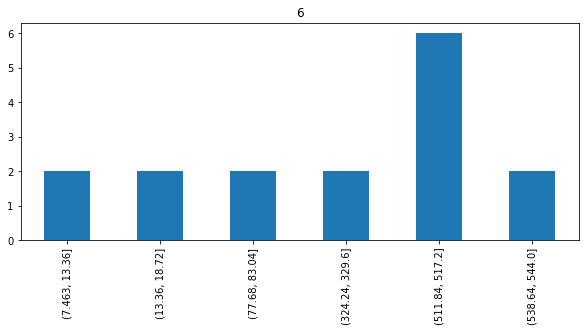

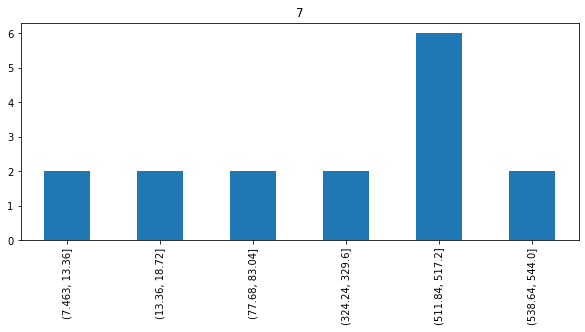

In [23]:
for rank in df['Rank'].unique()[:16]:
    tl = profile.GetIORequestDistribution(rank=rank)
    tl.plot(kind='bar', figsize=(10, 4), title=rank)
    plt.show()

### File summary of each file accessed by the Application

In [24]:
pp = pprint.PrettyPrinter(indent=1)
for file in df['Filename'].unique():
    if 'h5' in file:
        pp.pprint(profile.GetFileSummary(file,ext='h5'))
    else:
        pp.pprint(profile.GetFileSummary(file,ext='tfrecord',tf_record_features=dict(
                                        center=tf.io.FixedLenFeature(shape=[1, 3], dtype=tf.int64),
                                        label_volume_name=tf.io.FixedLenFeature(shape=[1], dtype=tf.string),)
                                        ))

{'ext': 'h5',
 'filename': 'img_0_of_1',
 'io_size': 40192,
 'io_time': 0.03180000000000001,
 'path': '/projects/datascience/dhari/dlio_datasets/ffn/img_0_of_1.h5',
 'size': 134252544,
 'special': {'keys': [{'name': 'labels',
                       'obj': <HDF5 dataset "labels": shape (4096,), type "<i8">,
                       'shape': (4096,),
                       'size': 4096,
                       'type': 'dataset'},
                      {'name': 'records',
                       'obj': <HDF5 dataset "records": shape (4096, 64, 64), type "<f8">,
                       'shape': (4096, 64, 64),
                       'size': 16777216,
                       'type': 'dataset'}],
             'name': 'img_0_of_1',
             'type': 'group'}}


In [25]:
profile.CreateChromeTimeline(location="/home/dhari", filename="ffn_run1_p128_io.json")

[============================================================] 100.0% 128 of 128 Creating DXT Timeline 

[============================================================] 100.0% 1 of 1 Creating DXT Timeline 


{'traceEvents': [{'name': '/projects/datascience/dhari/dlio_datasets/ffn/img_0_of_1.h5',
   'cat': 'X_POSIX',
   'ph': 'B',
   'ts': 325600,
   'pid': 7,
   'tid': 0,
   'args': {'Module': 'X_POSIX',
    'Filename': '/projects/datascience/dhari/dlio_datasets/ffn/img_0_of_1.h5',
    'Rank': 7,
    'Operation': 'read',
    'Segment': 0,
    'Offset': 0,
    'Length': 8,
    'Start': 0.3256,
    'End': 0.3438}},
  {'name': '/projects/datascience/dhari/dlio_datasets/ffn/img_0_of_1.h5',
   'cat': 'X_POSIX',
   'ph': 'B',
   'ts': 325700,
   'pid': 6,
   'tid': 0,
   'args': {'Module': 'X_POSIX',
    'Filename': '/projects/datascience/dhari/dlio_datasets/ffn/img_0_of_1.h5',
    'Rank': 6,
    'Operation': 'read',
    'Segment': 0,
    'Offset': 0,
    'Length': 8,
    'Start': 0.3257,
    'End': 0.3439}},
  {'name': '/projects/datascience/dhari/dlio_datasets/ffn/img_0_of_1.h5',
   'cat': 'X_POSIX',
   'ph': 'B',
   'ts': 325800,
   'pid': 4,
   'tid': 0,
   'args': {'Module': 'X_POSIX',
    

### 